In [1]:
import os
import pandas as pd
import numpy as np
# ! pip install supervenn
from supervenn import supervenn

import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_dropbox_dir
from standardize import fill_na_by_cohort, standardize_across_cohorts

#### TODO List
 - save additional files that give information about the total number of peaks in each cohort id after frequency threshold but Before alignment

### Specify the directories and files

In [7]:
dropbox_dir = get_dropbox_dir()
base_dir = os.path.join(dropbox_dir, 'development_CohortCombination','alignment_RCC_2024_Feb_27')

matt_ft_dir = os.path.join(base_dir, 'matt_top_fts')
data_dir = os.path.join(base_dir,'alignment_id_29', 'merge_reference_freq_th_0.4_freq_th_0.1')

cohort_ids_to_labels_file = os.path.join(base_dir, 'cohort_ids_to_labels.csv')

## Import Matt's top Features

In [8]:
matt_ft_files = os.listdir(matt_ft_dir)
matt_ft_files = [f for f in matt_ft_files if f.endswith('.txt')]

matt_ft_dict = {}
for f in matt_ft_files:
    ft_name = f.strip('.txt')
    # with open(os.path.join(matt_ft_dir, f), 'r') as file:
    #     ft = file.read().split(', ')
    # if len(ft) == 1:
    with open(os.path.join(matt_ft_dir, f), 'r') as file:
        ft = file.read().splitlines()
        # print(file.read()
    # remove all of the ', and commas from the strings in the list
    ft = [x.strip(',').strip(' ').strip('"').strip("'").strip('\n').strip('\t') for x in ft]
    matt_ft_dict[ft_name] = ft
    # break
    print(ft_name + ': ' + str(len(ft)))




op_25_feats: 25
168_os_pfs_feats: 168
net_matched_feats: 86


In [9]:
# Helper functions to finding the number and percentage of captured features
def get_captured_fts(matt_ft_list, align_ft_list):
    captured_fts = [ft for ft in matt_ft_list if ft in align_ft_list]
    return captured_fts

def get_captured_perc(matt_ft_list, align_ft_list):
    captured_fts = get_captured_fts(matt_ft_list, align_ft_list)
    matt_capture_perc = len(captured_fts) / len(matt_ft_list)
    align_capture_perc = len(captured_fts) / len(align_ft_list)
    return matt_capture_perc, align_capture_perc

## Import the Alignment Results

In [10]:
cohort_id_file = os.path.join(data_dir, 'combined_study_cohort_ids.csv')
nan_mask_file = os.path.join(data_dir, 'combined_study_nan_mask.csv')
combined_study_file = os.path.join(data_dir, 'combined_study.csv')
align_score_file = os.path.join(data_dir, 'align_score_df.csv')
align_feats_file = os.path.join(data_dir, 'alignment_df.csv')


umap_file = os.path.join(data_dir, 'umap_df_zscore.csv')
pca_file = os.path.join(data_dir, 'pca_df_zscore.csv')

In [11]:
# Create the pretraining metadata
cohort_ids_to_labels_df = pd.read_csv(cohort_ids_to_labels_file, index_col=0)
cohort_id_df = pd.read_csv(cohort_id_file, index_col=0)
cohort_id_df.set_index('file_name', inplace=True)
cohort_id_df.columns = ['cohort_id']
metadata_df = cohort_id_df.join(cohort_ids_to_labels_df, on='cohort_id')
# turn the cohort id into a string
metadata_df['cohort_id'] = metadata_df['cohort_id'].astype(str)

study_id_to_label = metadata_df.groupby('Study ID')['Cohort Label'].first().to_dict()
cohort_id_to_label = metadata_df.groupby('cohort_id')['Cohort Label'].first().to_dict()
cohort_id_to_study_id = metadata_df.groupby('cohort_id')['Study ID'].first().to_dict()

In [12]:
# information about the reference cohort
ref_cohort_id = '541'
num_ref_cohort_peaks = np.nan
#TODO Save the number of peaks in the reference cohort used for alignment

In [13]:
# Get the alignment scores
align_scores = pd.read_csv(align_score_file, index_col=0)
align_scores.index = align_scores.index.astype(str)
cohort_id_to_align_score = align_scores.iloc[:,0].to_dict()
cohort_id_to_align_score[ref_cohort_id] = 1.0

In [14]:
# Create the unique color maps to consistent plotting across the different plots

# join the following colormaps Accent, Dark2, Set2, Pastel2
my_32_colors = plt.cm.Accent.colors + plt.cm.Dark2.colors + plt.cm.Set2.colors + plt.cm.Pastel2.colors
my_10_colors = plt.cm.tab10.colors
my_20_colors = plt.cm.tab20.colors 
my_42_colors = my_10_colors + my_32_colors
my_52_colors = my_20_colors + my_32_colors

def get_color_map(n):
    if n <= 10:
        return my_10_colors
    elif n <= 20:
        return my_20_colors
    elif n <= 32:
        return my_32_colors
    elif n <= 42:
        return my_42_colors
    elif n <= 52:
        return my_52_colors
    else:
        # create a colormap from turbo
        return plt.cm.turbo(np.linspace(0, 1, n))
    
def assign_color_map(unique_vals):
    my_colors = get_color_map(len(unique_vals))
    color_map = dict(zip(np.sort(unique_vals), my_colors))
    return color_map

In [15]:
# Create cohort ids for the RCC subsets
rcc1_files = [f for f in metadata_df.index if 'RCC_HP' in f]
print(len(rcc1_files))
rcc3_files = [f for f in metadata_df[metadata_df['cohort_id']==ref_cohort_id].index if 'RCC_HP' not in f]
print(len(rcc3_files))

metadata_df['Cohort ID Expanded'] = metadata_df['cohort_id']
metadata_df['Study ID Expanded'] = metadata_df['Study ID']
metadata_df.loc[rcc1_files, 'Cohort ID Expanded'] = 'RCC1'
metadata_df.loc[rcc3_files, 'Cohort ID Expanded'] = 'RCC3'
metadata_df.loc[rcc1_files, 'Study ID Expanded'] = 'ST001236'
metadata_df.loc[rcc3_files, 'Study ID Expanded'] = 'ST001237'

271
1379


In [21]:
print(np.sort(metadata_df['Cohort Label'].unique()))

['adult_cancer' 'adult_other' 'pediatric_CMD' 'pediatric_other']


In [22]:
cohort_label_to_color = assign_color_map(metadata_df['Cohort Label'].unique())
study_id_to_color = {k:cohort_label_to_color[v] for k,v in study_id_to_label.items()}
cohort_id_to_color = {k:cohort_label_to_color[v] for k,v in cohort_id_to_label.items()}

study_id_to_uniq_color = assign_color_map(metadata_df['Study ID'].unique())
cohort_id_to_uniq_color = assign_color_map(metadata_df['cohort_id'].unique())

[WARNING] /var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_25693/1784223509.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=color, label=label)



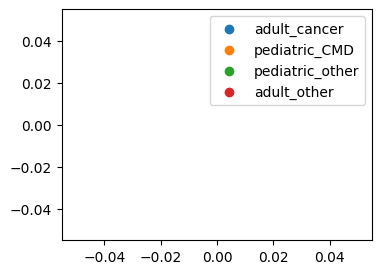

In [23]:
# create a plot that displays the color along with the cohort label
fig, ax = plt.subplots(figsize=(4,3))
for label, color in cohort_label_to_color.items():
    ax.scatter([], [], c=color, label=label)
ax.legend()

In [24]:
metadata_df.head()

,cohort_id,Study ID,Cohort Label,Cohort ID Expanded,Study ID Expanded
file_name,,,,,
1010_Marios_PD1_Inhib2_HP-E9204600-7.mzML,541,RCC,adult_cancer,RCC3,ST001237
1040b_Marios_PD1_Inhib2_HP-PREFB54.mzML,541,RCC,adult_cancer,RCC3,ST001237
0921_Marios_PD1_Inhib2_HP-AF048325-8.mzML,541,RCC,adult_cancer,RCC3,ST001237
0401_Marios_PD1_Inhib2_HP-AD657189-7.mzML,541,RCC,adult_cancer,RCC3,ST001237
0224_Marios_PD1_Inhib2_HP-S3473954-7.mzML,541,RCC,adult_cancer,RCC3,ST001237


In [25]:
metadata_summary = pd.DataFrame()
metadata_summary['Cohort ID'] = metadata_df['cohort_id'].unique()
metadata_summary['Cohort ID'] = metadata_summary['Cohort ID'].astype(str)
metadata_summary['Cohort Label'] = metadata_summary['Cohort ID'].map(cohort_id_to_label)
metadata_summary['Study ID'] = metadata_summary['Cohort ID'].map(cohort_id_to_study_id)
metadata_summary['Number of Samples'] = metadata_summary['Cohort ID'].map(metadata_df['cohort_id'].value_counts())
metadata_summary['Alignment Score'] = metadata_summary['Cohort ID'].map(cohort_id_to_align_score)

In [26]:
print('Number of samples: ' + str(metadata_summary['Number of Samples'].sum()))
print('Number of cohorts: ' + str(metadata_summary.shape[0]))
print('Number of Study IDs: ' + str(metadata_summary['Study ID'].nunique()))
print('Number of Cohort Labels: ' + str(metadata_summary['Cohort Label'].nunique()))

Number of samples: 16244
Number of cohorts: 23
Number of Study IDs: 18
Number of Cohort Labels: 4


In [27]:
num_aligned_list = []
matt_captured_peaks_dct = {}
for cohort_id in metadata_summary['Cohort ID']:
    if cohort_id == ref_cohort_id:
        num_aligned_list.append(np.nan)
        for matt_ft_name, matt_ft_list in matt_ft_dict.items():
            # matt_captured_peaks_dct[(cohort_id, matt_ft_name)] = np.nan
            matt_captured_peaks_dct[(cohort_id, matt_ft_name)] = len(matt_ft_list)
        continue
    
    pair_alignment_file = os.path.join(data_dir,f'{cohort_id}_aligned_to_{ref_cohort_id}_with_merge.csv')
    pair_alignment_df = pd.read_csv(pair_alignment_file, index_col=0)
    pair_alignment_df.columns = pair_alignment_df.columns.astype(str)
    pair_alignment_df.dropna(inplace=True)
    num_aligned_fts = pair_alignment_df.shape[0]
    num_aligned_list.append(num_aligned_fts)

    rcc_ft_ids = pair_alignment_df[ref_cohort_id].to_list()
    for matt_ft_name, matt_ft_list in matt_ft_dict.items():
        matt_captured_peaks_dct[(cohort_id, matt_ft_name)] = len(get_captured_fts(matt_ft_list, rcc_ft_ids))

metadata_summary['Number of Initial Aligned Peaks'] = num_aligned_list

# not the correct value of the the original number of peaks, we need other files to extract this information
# metadata_summary['Number of Original Peaks'] = round(metadata_summary['Number of Initial Aligned Peaks']/metadata_summary['Alignment Score'])

for matt_ft_name, matt_ft_list in matt_ft_dict.items():
    metadata_summary[matt_ft_name + ' Captured # (Initial)'] = metadata_summary['Cohort ID'].map(lambda x: matt_captured_peaks_dct[(x, matt_ft_name)])
    metadata_summary[matt_ft_name + ' Captured % (Initial)'] = metadata_summary[matt_ft_name + ' Captured # (Initial)']/len(matt_ft_list)


In [28]:
metadata_summary.to_csv(os.path.join(data_dir, 'metadata_summary.csv'))
metadata_summary.head()

,Cohort ID,Cohort Label,Study ID,Number of Samples,Alignment Score,Number of Initial Aligned Peaks,op_25_feats Captured # (Initial),op_25_feats Captured % (Initial),168_os_pfs_feats Captured # (Initial),168_os_pfs_feats Captured % (Initial),net_matched_feats Captured # (Initial),net_matched_feats Captured % (Initial)
0,541,adult_cancer,RCC,1650,1.000000,NaN,25,1.00,168,1.000000,86,1.000000
1,502,adult_cancer,ST001422,2075,0.335301,1873.0,13,0.52,78,0.464286,39,0.453488
2,503,pediatric_CMD,ST001428,1542,0.283951,1586.0,7,0.28,44,0.261905,20,0.232558
3,505,pediatric_other,ST001931,2046,0.246545,1319.0,9,0.36,53,0.315476,22,0.255814
4,507,adult_other,ST002112,335,0.486491,2718.0,16,0.64,101,0.601190,56,0.651163


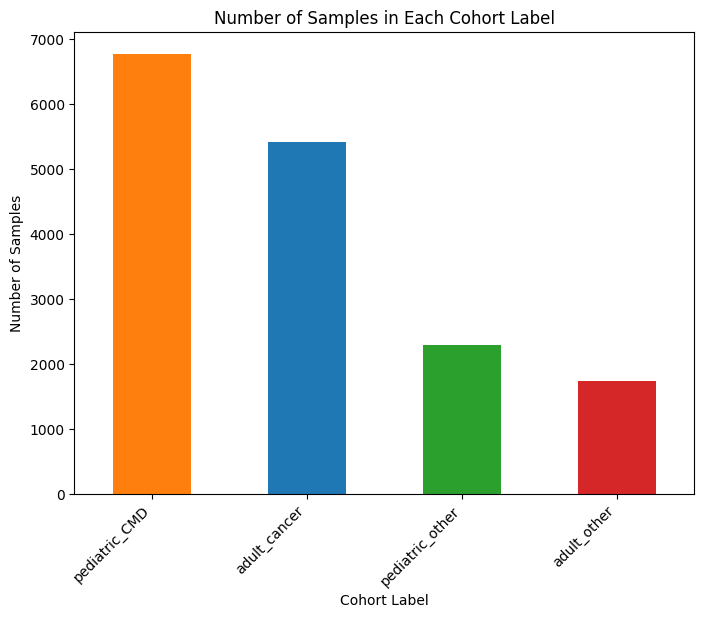

In [29]:
# create a plot of the number of samples in each cohort Label
fig, ax = plt.subplots(figsize=(8,6))
temp = metadata_summary.groupby('Cohort Label')['Number of Samples'].sum().sort_values(ascending=False)
temp.plot(kind='bar', ax=ax, color=[cohort_label_to_color[label] for label in temp.index])
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples in Each Cohort Label')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

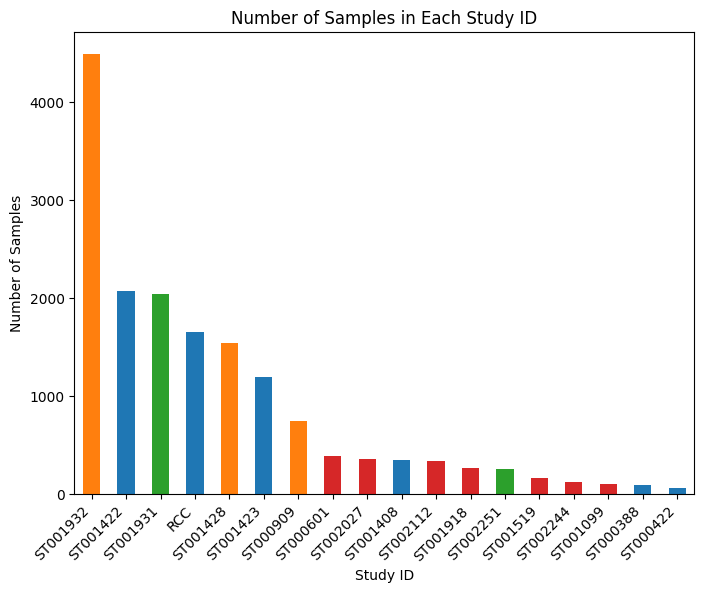

In [30]:
# create a plot of the number of samples in each Study ID
fig, ax = plt.subplots(figsize=(8,6))
temp = metadata_summary.groupby('Study ID')['Number of Samples'].sum().sort_values(ascending=False)
temp.plot(kind='bar', ax=ax, color=[study_id_to_color[label] for label in temp.index])
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples in Each Study ID')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[WARNING] /var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_25693/503404079.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')



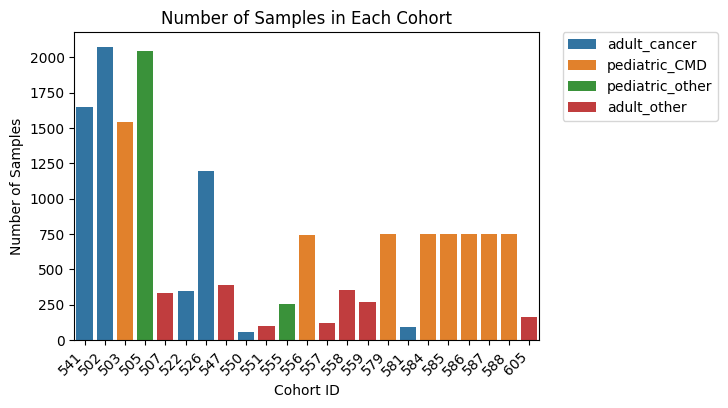

In [31]:
# create a plot of the number of samples in each cohort
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=metadata_summary, x='Cohort ID', y='Number of Samples', palette=cohort_label_to_color, hue='Cohort Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples in Each Cohort')
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[WARNING] /var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_25693/192008107.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')



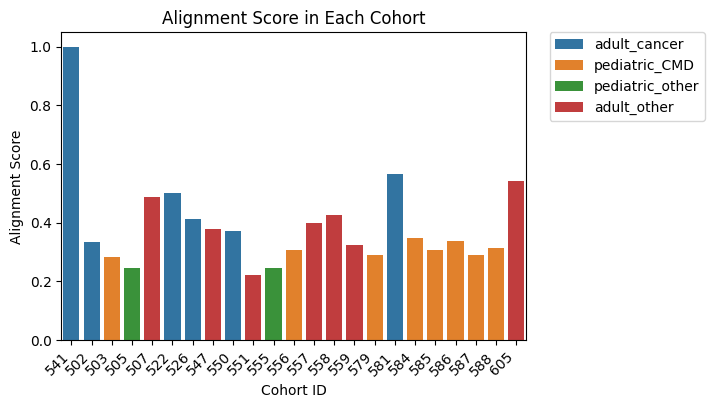

In [32]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=metadata_summary, x='Cohort ID', y='Alignment Score', palette=cohort_label_to_color, hue='Cohort Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel('Alignment Score')
ax.set_title('Alignment Score in Each Cohort')
# place legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [29]:
# fig, ax = plt.subplots(figsize=(6,4))
# sns.barplot(data=metadata_summary, x='Cohort ID', y='Number of Original Peaks', palette=cohort_label_to_color, hue='Cohort Label')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# # ax.set_ylabel('Alignment Score')
# ax.set_title('Number of Original Peaks in Each Cohort')
# # place legend outside of the plot
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[WARNING] /var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_25693/4126420396.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')



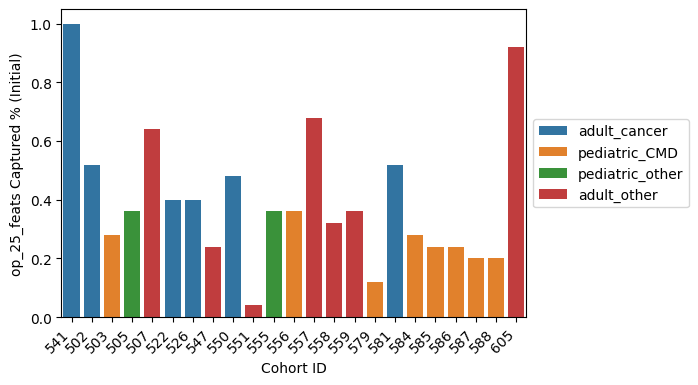

In [33]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=metadata_summary, x='Cohort ID', y='op_25_feats Captured % (Initial)', palette=cohort_label_to_color, hue='Cohort Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# ax.set_ylabel('Alignment Score')
# ax.set_title('Number of Original Peaks in Each Cohort')
# place legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[WARNING] /var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_48180/3112497038.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')



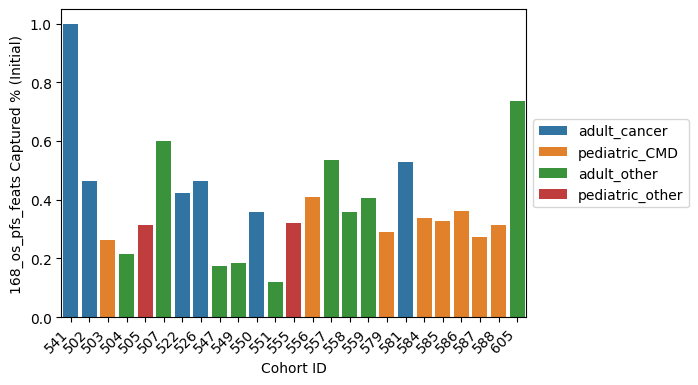

In [33]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=metadata_summary, x='Cohort ID', y='168_os_pfs_feats Captured % (Initial)', palette=cohort_label_to_color, hue='Cohort Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# ax.set_ylabel('Alignment Score')
# ax.set_title('Number of Original Peaks in Each Cohort')
# place legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[WARNING] /var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_48180/3362809063.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')



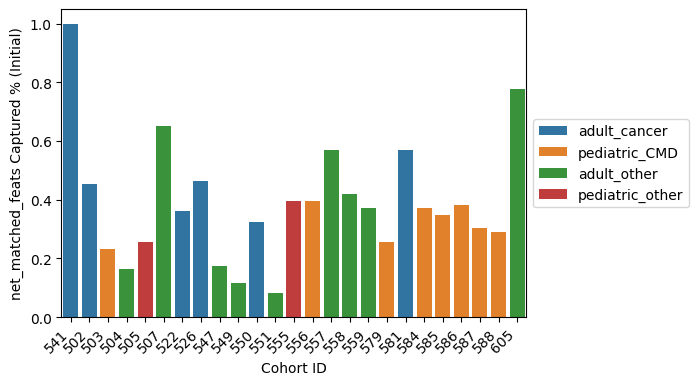

In [34]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=metadata_summary, x='Cohort ID', y='net_matched_feats Captured % (Initial)', palette=cohort_label_to_color, hue='Cohort Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# ax.set_ylabel('Alignment Score')
# ax.set_title('Number of Original Peaks in Each Cohort')
# place legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[WARNING] /var/folders/zk/pr84pr3n16z3yzz_rrstxmmc0000gn/T/ipykernel_48180/32730309.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')



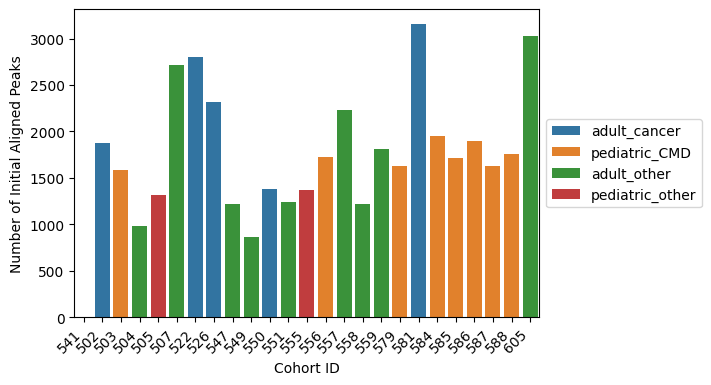

In [31]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=metadata_summary, x='Cohort ID', y='Number of Initial Aligned Peaks', palette=cohort_label_to_color, hue='Cohort Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# ax.set_ylabel('Alignment Score')
# ax.set_title('Number of Original Peaks in Each Cohort')
# place legend outside of the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [35]:
metadata_summary

,Cohort ID,Cohort Label,Study ID,Number of Samples,Alignment Score,Number of Initial Aligned Peaks,Number of Original Peaks,op_25_feats Captured # (Initial),op_25_feats Captured % (Initial),168_os_pfs_feats Captured # (Initial),168_os_pfs_feats Captured % (Initial),net_matched_feats Captured # (Initial),net_matched_feats Captured % (Initial)
0,541,adult_cancer,RCC,1650,1.000000,NaN,NaN,25,1.00,168,1.000000,86,1.000000
1,502,adult_cancer,ST001422,2075,0.335301,1873.0,5586.0,13,0.52,78,0.464286,39,0.453488
2,503,pediatric_CMD,ST001428,1542,0.283951,1586.0,5585.0,7,0.28,44,0.261905,20,0.232558
3,504,adult_other,ST001849,691,0.174808,976.0,5583.0,4,0.16,36,0.214286,14,0.162791
4,505,pediatric_other,ST001931,2046,0.246545,1319.0,5350.0,9,0.36,53,0.315476,22,0.255814
5,507,adult_other,ST002112,335,0.486491,2718.0,5587.0,16,0.64,101,0.601190,56,0.651163
6,522,adult_cancer,ST001408,349,0.501163,2800.0,5587.0,10,0.40,71,0.422619,31,0.360465
7,526,adult_cancer,ST001423,1197,0.414028,2313.0,5587.0,10,0.40,78,0.464286,40,0.465116
8,547,adult_other,ST000601,393,0.380374,1220.0,3207.0,6,0.24,29,0.172619,15,0.174419
9,549,adult_other,ST001259,139,0.153874,859.0,5583.0,3,0.12,31,0.184524,10,0.116279


## Original Peak Intensity Analysis

In [43]:
# Helper Functions

def create_plot(plot_df, hue_col, palette_dict,include_MV=True,sz=None):
    if 'UMAP1' in plot_df.columns:
        x_col = 'UMAP1'
        y_col = 'UMAP2'
    else:
        x_col = 'PC1'
        y_col = 'PC2'

    if sz is None:
        sz = 10/np.log2(plot_df.shape[0])
        print('marker size: ', sz)

    fig, ax = plt.subplots(figsize=(6,6))
    sns.scatterplot(data=plot_df, x=x_col, y=y_col, hue=hue_col, palette=palette_dict, ax=ax, s=sz)
    
        # place the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # edit the legend to include the number of samples in each cohort
    handles, labels = ax.get_legend_handles_labels()
    if include_MV:
        labels = [f'{label} (N={plot_df[plot_df[hue_col]==label].shape[0]}, MV%={plot_df[plot_df[hue_col]==label]["MV"].mean():.0f})' for label in labels]
    else:
        labels = [f'{label} (N={plot_df[plot_df[hue_col]==label].shape[0]})' for label in labels]

    # make the size of the markers in the handles larger
    for handle in handles:
        # print(dir(handle))
        handle.set_markersize(10)
        # handle._sizes = [100]
    
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return fig, ax

### UMAP plot

In [37]:
umap_df = pd.read_csv(umap_file, index_col=0)
umap_df = umap_df.loc[metadata_df.index]
umap_df['Cohort Label'] = metadata_df['Cohort Label']
umap_df['Study ID'] = metadata_df['Study ID']
umap_df['Cohort ID'] = metadata_df['cohort_id']
umap_df['MV'] = umap_df['MV percentage'].apply(lambda x: x.strip('%')).astype(float)

marker size:  0.7112621660523728


(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='UMAP1', ylabel='UMAP2'>)

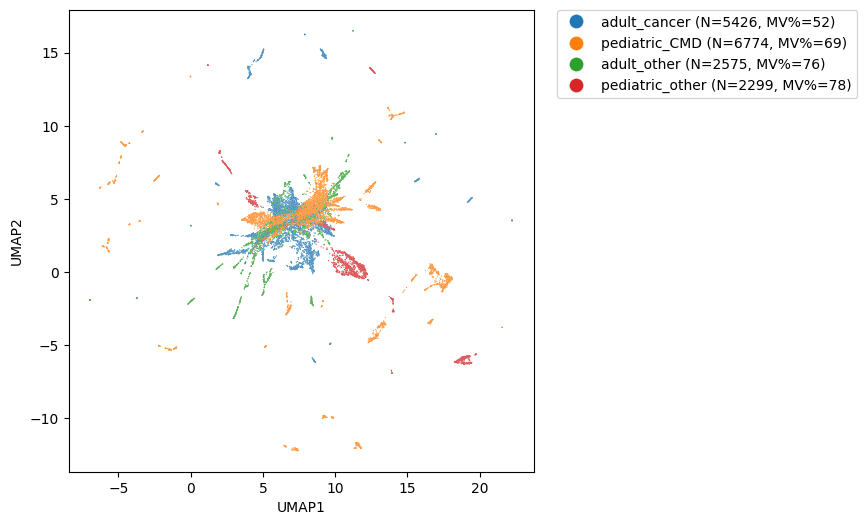

In [44]:
create_plot(umap_df, 'Cohort Label', cohort_label_to_color)

marker size:  0.7112621660523728


(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='UMAP1', ylabel='UMAP2'>)

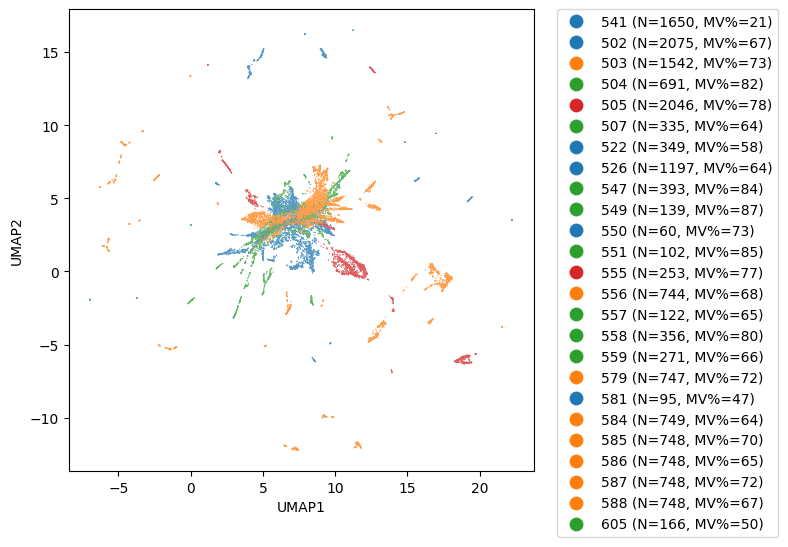

In [45]:
create_plot(umap_df, 'Cohort ID', cohort_id_to_color)

marker size:  0.7112621660523728


(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='UMAP1', ylabel='UMAP2'>)

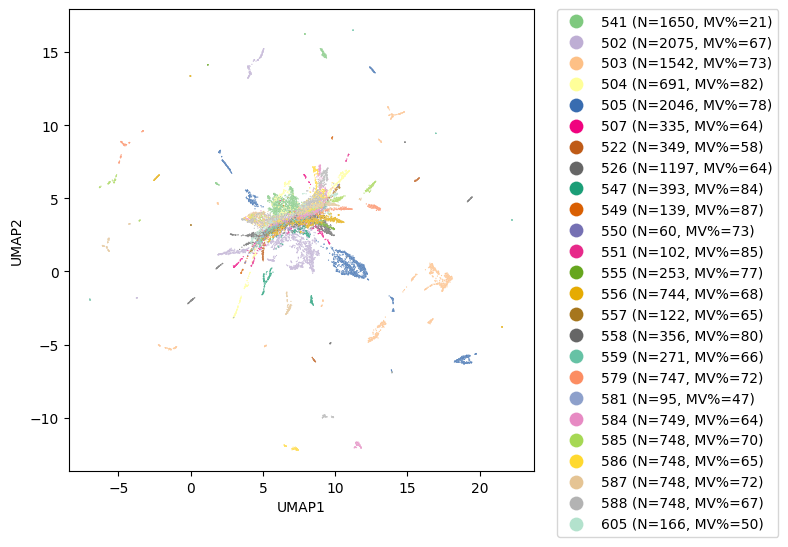

In [46]:
create_plot(umap_df, 'Cohort ID', cohort_id_to_uniq_color)

marker size:  0.7112621660523728


(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='UMAP1', ylabel='UMAP2'>)

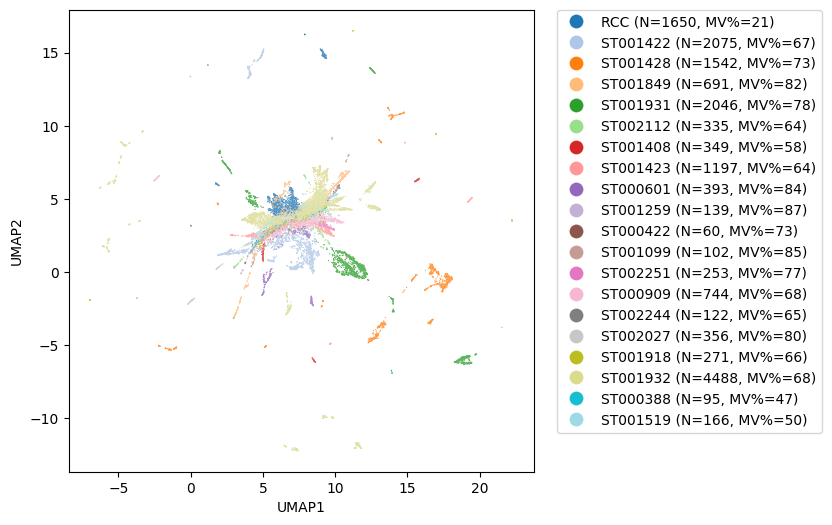

In [47]:
create_plot(umap_df, 'Study ID', study_id_to_uniq_color)

### PCA Plot

In [48]:
pca_df = pd.read_csv(pca_file, index_col=0)
pca_df = pca_df.loc[metadata_df.index]
pca_df['Cohort Label'] = metadata_df['Cohort Label'] #+ '(N=' + metadata_df['cohort_id'].map(metadata_df['cohort_id'].value_counts().astype(str)) + ')'
pca_df['Study ID'] = metadata_df['Study ID']
pca_df['Cohort ID'] = metadata_df['cohort_id']
pca_df['MV'] = pca_df['MV percentage'].apply(lambda x: x.strip('%')).astype(float)


marker size:  0.7112621660523728


(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='PC1', ylabel='PC2'>)

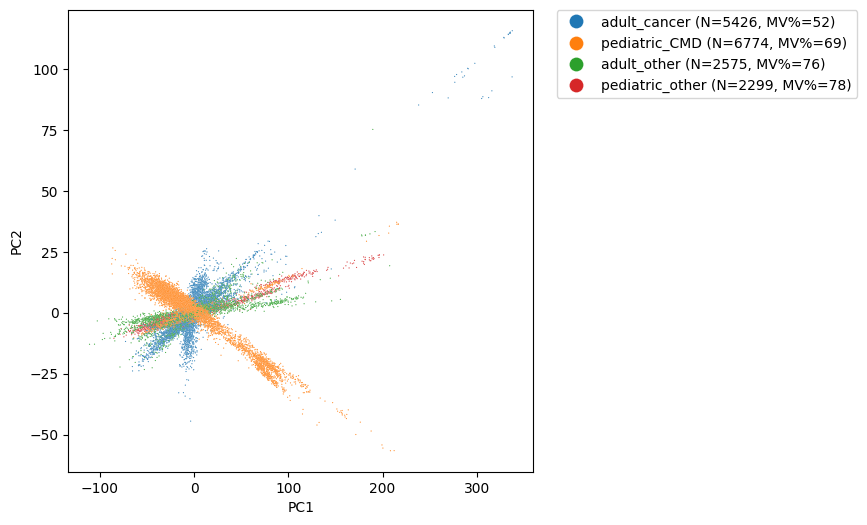

In [49]:
create_plot(pca_df, 'Cohort Label', cohort_label_to_color)

marker size:  0.7112621660523728


(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='PC1', ylabel='PC2'>)

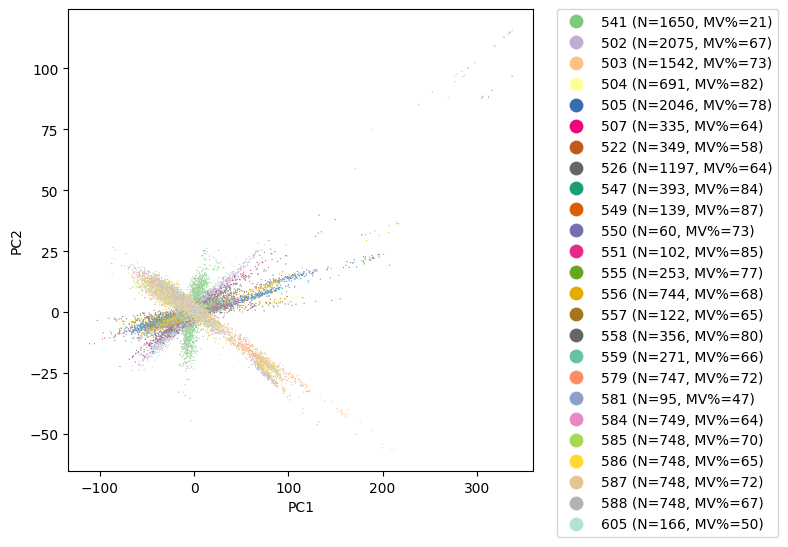

In [50]:
create_plot(pca_df, 'Cohort ID', cohort_id_to_uniq_color)

marker size:  0.7112621660523728


(<Figure size 600x600 with 1 Axes>, <Axes: xlabel='PC1', ylabel='PC2'>)

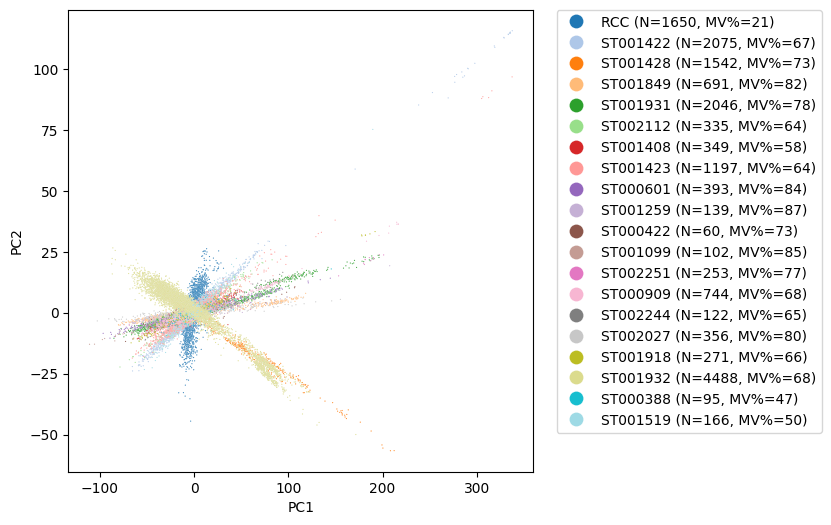

In [51]:
create_plot(pca_df, 'Study ID', study_id_to_uniq_color)

## Choose a Subset of the Aligned Features

In [34]:
## Helper Functions


# function to get the sets of aligned features across each cohort id
def get_align_summary(alignment_df, ref_id, filter_th=0, incl_ref_col=True):

    # ref_fts = alignment_df[ref_id]
    align_summary = alignment_df.copy()
    align_summary.set_index(ref_id, inplace=True)
    nan_locs = align_summary.isna()
    ref_fts = align_summary.index

    for col in align_summary.columns:
        align_summary[col] = ref_fts

    align_summary[nan_locs] = None  

    if isinstance(filter_th, int) or isinstance(filter_th, float):
        if filter_th > len(align_summary.columns):
            raise ValueError('filter_th must be less than the number of columns in the alignment_df')
        if filter_th > 0:
            align_summary = align_summary[align_summary.count(axis=1) >= filter_th].copy()
        elif filter_th < 0:
            raise ValueError('filter_th must be a positive integer')
        
    elif isinstance(filter_th, list):
        align_summary = align_summary.loc[filter_th,:].copy()
    else:
        raise ValueError('filter_th must be an int or a list')

    if incl_ref_col:
        align_summary[ref_id] = align_summary.index
        align_summary = align_summary[[ref_id] + align_summary.columns.tolist()[:-1]].copy()

    return align_summary

def convert_align_summary_to_sets(align_summary):
    sets = [set(align_summary[col].dropna()) for col in align_summary.columns]
    set_names = align_summary.columns
    return sets, set_names

In [35]:
# Load the original alignment summary
alignment_df = pd.read_csv(align_feats_file)
alignment_df.columns = alignment_df.columns.astype(str)
alignment_df.dropna(axis=0, how='all', inplace=True)

In [36]:
align_summary = get_align_summary(alignment_df, ref_cohort_id, filter_th=0)

cohort_id_to_sample_num = metadata_summary[['Cohort ID','Number of Samples']].copy()
cohort_id_to_sample_num.set_index('Cohort ID', inplace=True)

align_summary_bool = align_summary.astype(bool).astype(int).T
align_summary_bool.index.name = 'Cohort ID'

number_samples_by_ft = align_summary_bool.mul(cohort_id_to_sample_num['Number of Samples'], axis=0)
tot_num_samples = cohort_id_to_sample_num['Number of Samples'].sum()
print('Total number of samples: ', tot_num_samples)


Total number of samples:  16244


In [128]:
output_dct = {}

for min_num_cohort_ids in range(0,20):
    align_summary = get_align_summary(alignment_df, ref_cohort_id, filter_th=min_num_cohort_ids)

    chosen_feats = align_summary[ref_cohort_id].dropna().to_list()
# print(f'Number of chosen features found in {min_num_cohort_ids+1}/{tot_num_cohort_ids} cohort ids: ', len(chosen_feats))

    sets, set_names = convert_align_summary_to_sets(align_summary)

    subset_summary = metadata_summary.copy()
    subset_summary.set_index('Cohort ID', inplace=True)
    subset_summary['Number of Subset Aligned Peaks'] = align_summary.count(axis=0)
    # subset_summary['Estimated Avg Peak Frequency'] = (number_samples_by_ft[chosen_feats].sum(axis=0)/tot_num_samples).mean()
    estimate_avg_peak_freq = (number_samples_by_ft[chosen_feats].sum(axis=0)/tot_num_samples).mean()

    matt_captured_peaks = {}
    num_of_matt_fts = {}

    for matt_ft_name, matt_ft_list in matt_ft_dict.items():
        # captured_peaks = [len(get_captured_fts(matt_ft_list, s)) for s in sets]
        captured_peaks = [len(get_captured_fts(matt_ft_list, s)) for s in sets]
        matt_captured_peaks[matt_ft_name] = captured_peaks
        num_of_matt_fts[matt_ft_name] = len(matt_ft_list)
        subset_summary[matt_ft_name + ' Captured # (Subset)'] = captured_peaks
        subset_summary[matt_ft_name + ' Captured % (Subset)'] = round(subset_summary[matt_ft_name + ' Captured # (Subset)'] / num_of_matt_fts[matt_ft_name],3)

    output_dct[min_num_cohort_ids] = {
        'Number of Aligned Peaks': align_summary.shape[0],
        'Avg Peak Frequency Upper Bound': estimate_avg_peak_freq}

    for matt_ft_name in matt_ft_dict.keys():
        output_dct[min_num_cohort_ids][matt_ft_name + ' Captured # (Subset)'] = subset_summary[matt_ft_name + ' Captured # (Subset)'].max()
        output_dct[min_num_cohort_ids][matt_ft_name + ' Captured % (Subset)'] = subset_summary[matt_ft_name + ' Captured # (Subset)'].max() / num_of_matt_fts[matt_ft_name]
        

output = pd.DataFrame(output_dct).T        

In [130]:
# number_samples_by_ft[chosen_feats].sum(axis=0)/tot_num_samples
output

,Number of Aligned Peaks,Avg Peak Frequency Upper Bound,op_25_feats Captured # (Subset),op_25_feats Captured % (Subset),168_os_pfs_feats Captured # (Subset),168_os_pfs_feats Captured % (Subset),net_matched_feats Captured # (Subset),net_matched_feats Captured % (Subset)
0,5409.0,0.385733,25.0,1.00,164.0,0.976190,86.0,1.000000
1,5409.0,0.385733,25.0,1.00,164.0,0.976190,86.0,1.000000
2,5168.0,0.398338,25.0,1.00,162.0,0.964286,86.0,1.000000
3,4776.0,0.419528,24.0,0.96,153.0,0.910714,83.0,0.965116
4,4350.0,0.443685,23.0,0.92,141.0,0.839286,75.0,0.872093
5,3872.0,0.473207,20.0,0.80,123.0,0.732143,64.0,0.744186
6,3448.0,0.501789,18.0,0.72,111.0,0.660714,60.0,0.697674
7,3013.0,0.533328,15.0,0.60,99.0,0.589286,52.0,0.604651
8,2612.0,0.564063,14.0,0.56,89.0,0.529762,47.0,0.546512
9,2256.0,0.593070,10.0,0.40,77.0,0.458333,38.0,0.441860


<Axes: xlabel='Number of Aligned Peaks', ylabel='op_25_feats Captured % (Subset)'>

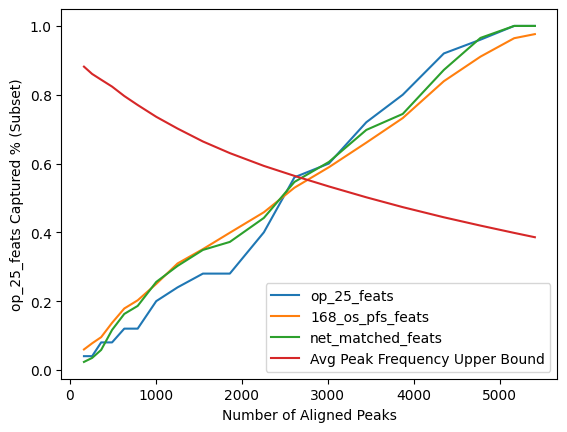

In [132]:
sns.lineplot(data=output, x='Number of Aligned Peaks', y='op_25_feats Captured % (Subset)', label='op_25_feats')
sns.lineplot(data=output, x='Number of Aligned Peaks', y='168_os_pfs_feats Captured % (Subset)', label='168_os_pfs_feats')
sns.lineplot(data=output, x='Number of Aligned Peaks', y='net_matched_feats Captured % (Subset)', label='net_matched_feats')
sns.lineplot(data=output, x='Number of Aligned Peaks', y='Avg Peak Frequency Upper Bound', label='Avg Peak Frequency Upper Bound')



In [133]:
not_nan_mask = ~pd.read_csv(nan_mask_file, index_col=0)


In [165]:
not_nan_mask.shape

(3448, 17074)

In [156]:
(not_nan_mask.loc[chosen_feats].sum(axis=1)/not_nan_mask.shape[1]).sort_values(ascending=False)

FT5009    0.900375
FT4848    0.890477
FT5276    0.889423
FT7966    0.888544
FT8370    0.878119
            ...   
FT3097    0.463277
FT6153    0.458006
FT9395    0.448694
FT5860    0.380110
FT9756    0.367986
Length: 163, dtype: float64

In [159]:
temp_df = alignment_df.set_index(ref_cohort_id)
temp_df.loc['FT5860']

In [163]:
temp_df.loc['FT5860']

Cohort ID
504       NaN
551    FT2406
587    FT3455
550    FT2853
584    FT5074
549    FT1624
558    FT3148
581    FT6355
547       NaN
556    FT3987
503    FT4502
579    FT3742
502    FT4511
557    FT9754
526    FT4889
522    FT3289
588    FT5173
585    FT4066
586    FT5255
605    FT7913
559    FT5000
507    FT9137
505       NaN
555       NaN
Name: FT5860, dtype: object

In [142]:
output_dct = {}


for min_num_cohort_ids in range(0,20):
    align_summary = get_align_summary(alignment_df, ref_cohort_id, filter_th=min_num_cohort_ids)

    chosen_feats = align_summary[ref_cohort_id].dropna().to_list()
# print(f'Number of chosen features found in {min_num_cohort_ids+1}/{tot_num_cohort_ids} cohort ids: ', len(chosen_feats))

    sets, set_names = convert_align_summary_to_sets(align_summary)

    subset_summary = metadata_summary.copy()
    subset_summary.set_index('Cohort ID', inplace=True)
    subset_summary['Number of Subset Aligned Peaks'] = align_summary.count(axis=0)
    # subset_summary['Estimated Avg Peak Frequency'] = (number_samples_by_ft[chosen_feats].sum(axis=0)/tot_num_samples).mean()
    
    estimate_avg_peak_freq = (number_samples_by_ft[chosen_feats].sum(axis=0)/tot_num_samples).mean()

    if all([c in not_nan_mask.index for c in chosen_feats]):

        avg_peak_freq = (not_nan_mask.loc[chosen_feats].sum(axis=1)/not_nan_mask.shape[1]).mean()
    else:
        avg_peak_freq = np.nan

    matt_captured_peaks = {}
    num_of_matt_fts = {}

    for matt_ft_name, matt_ft_list in matt_ft_dict.items():
        # captured_peaks = [len(get_captured_fts(matt_ft_list, s)) for s in sets]
        captured_peaks = [len(get_captured_fts(matt_ft_list, s)) for s in sets]
        matt_captured_peaks[matt_ft_name] = captured_peaks
        num_of_matt_fts[matt_ft_name] = len(matt_ft_list)
        subset_summary[matt_ft_name + ' Captured # (Subset)'] = captured_peaks
        subset_summary[matt_ft_name + ' Captured % (Subset)'] = round(subset_summary[matt_ft_name + ' Captured # (Subset)'] / num_of_matt_fts[matt_ft_name],3)

    output_dct[min_num_cohort_ids] = {
        'Number of Aligned Peaks': align_summary.shape[0],
        'Avg Peak Frequency': avg_peak_freq,
        'Avg Peak Frequency Estimate' : estimate_avg_peak_freq}


    for matt_ft_name in matt_ft_dict.keys():
        output_dct[min_num_cohort_ids][matt_ft_name + ' Captured # (Subset)'] = subset_summary[matt_ft_name + ' Captured # (Subset)'].max()
        output_dct[min_num_cohort_ids][matt_ft_name + ' Captured % (Subset)'] = subset_summary[matt_ft_name + ' Captured # (Subset)'].max() / num_of_matt_fts[matt_ft_name]
        

output = pd.DataFrame(output_dct).T        

Text(0, 0.5, 'Percentage')

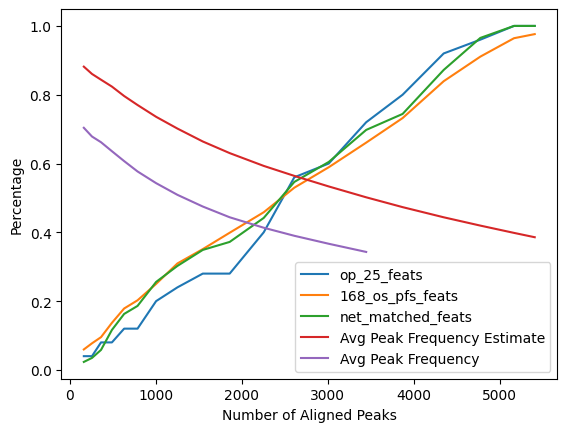

In [149]:
sns.lineplot(data=output, x='Number of Aligned Peaks', y='op_25_feats Captured % (Subset)', label='op_25_feats')
sns.lineplot(data=output, x='Number of Aligned Peaks', y='168_os_pfs_feats Captured % (Subset)', label='168_os_pfs_feats')
sns.lineplot(data=output, x='Number of Aligned Peaks', y='net_matched_feats Captured % (Subset)', label='net_matched_feats')
sns.lineplot(data=output, x='Number of Aligned Peaks', y='Avg Peak Frequency Estimate', label='Avg Peak Frequency Estimate')
sns.lineplot(data=output, x='Number of Aligned Peaks', y='Avg Peak Frequency', label='Avg Peak Frequency')
plt.ylabel('Percentage')

### Choose a subset of the aligned peaks

In [41]:
min_num_cohort_ids = 6 #6 was chosen originally
tot_num_cohort_ids = len(alignment_df.columns)
align_summary = get_align_summary(alignment_df, ref_cohort_id, filter_th=min_num_cohort_ids)

chosen_feats = align_summary[ref_cohort_id].dropna().to_list()
print(f'Number of chosen features found in {min_num_cohort_ids+1}/{tot_num_cohort_ids} cohort ids: ', len(chosen_feats))

sets, set_names = convert_align_summary_to_sets(align_summary)

subset_summary = metadata_summary.copy()
subset_summary.set_index('Cohort ID', inplace=True)
subset_summary['Number of Subset Aligned Peaks'] = align_summary.count(axis=0)

Number of chosen features found in 7/23 cohort ids:  3293


In [42]:
# find out how many of matt's top features are captured in the algin_summary
matt_captured_peaks = {}
num_of_matt_fts = {}

for matt_ft_name, matt_ft_list in matt_ft_dict.items():
    # captured_peaks = [len(get_captured_fts(matt_ft_list, s)) for s in sets]
    captured_peaks = [len(get_captured_fts(matt_ft_list, s)) for s in sets]
    matt_captured_peaks[matt_ft_name] = captured_peaks
    num_of_matt_fts[matt_ft_name] = len(matt_ft_list)
    subset_summary[matt_ft_name + ' Captured # (Subset)'] = captured_peaks
    subset_summary[matt_ft_name + ' Captured % (Subset)'] = round(subset_summary[matt_ft_name + ' Captured # (Subset)'] / num_of_matt_fts[matt_ft_name],3)

for matt_ft_name in matt_ft_dict.keys():
    print(f'{matt_ft_name} captured % (Initial): {metadata_summary[matt_ft_name + " Captured % (Initial)"].max()}')
    print(f'{matt_ft_name} captured % (Subset): {subset_summary[matt_ft_name + " Captured % (Subset)"].max()}')

op_25_feats captured % (Initial): 1.0
op_25_feats captured % (Subset): 0.72
168_os_pfs_feats captured % (Initial): 1.0
168_os_pfs_feats captured % (Subset): 0.643
net_matched_feats captured % (Initial): 1.0
net_matched_feats captured % (Subset): 0.686


In [169]:
subset_summary

,Cohort Label,Study ID,Number of Samples,Alignment Score,Number of Initial Aligned Peaks,Number of Original Peaks,op_25_feats Captured # (Initial),op_25_feats Captured % (Initial),168_os_pfs_feats Captured # (Initial),168_os_pfs_feats Captured % (Initial),net_matched_feats Captured # (Initial),net_matched_feats Captured % (Initial),Number of Subset Aligned Peaks,op_25_feats Captured # (Subset),op_25_feats Captured % (Subset),168_os_pfs_feats Captured # (Subset),168_os_pfs_feats Captured % (Subset),net_matched_feats Captured # (Subset),net_matched_feats Captured % (Subset)
Cohort ID,,,,,,,,,,,,,,,,,,,
541,adult_cancer,RCC,1650,1.000000,NaN,NaN,25,1.00,168,1.000000,86,1.000000,3448,18,0.72,111,0.661,60,0.698
502,adult_cancer,ST001422,2075,0.335301,1873.0,5586.0,13,0.52,78,0.464286,39,0.453488,1562,4,0.16,33,0.196,11,0.128
503,pediatric_CMD,ST001428,1542,0.283951,1586.0,5585.0,7,0.28,44,0.261905,20,0.232558,1508,1,0.04,15,0.089,6,0.070
504,adult_other,ST001849,691,0.174808,976.0,5583.0,4,0.16,36,0.214286,14,0.162791,843,5,0.20,46,0.274,26,0.302
505,pediatric_other,ST001931,2046,0.246545,1319.0,5350.0,9,0.36,53,0.315476,22,0.255814,1206,9,0.36,53,0.315,24,0.279
507,adult_other,ST002112,335,0.486491,2718.0,5587.0,16,0.64,101,0.601190,56,0.651163,2001,7,0.28,57,0.339,32,0.372
522,adult_cancer,ST001408,349,0.501163,2800.0,5587.0,10,0.40,71,0.422619,31,0.360465,2054,3,0.12,27,0.161,8,0.093
526,adult_cancer,ST001423,1197,0.414028,2313.0,5587.0,10,0.40,78,0.464286,40,0.465116,1944,7,0.28,55,0.327,31,0.360
547,adult_other,ST000601,393,0.380374,1220.0,3207.0,6,0.24,29,0.172619,15,0.174419,887,11,0.44,72,0.429,40,0.465


In [ ]:
# print summary
# print number of features captured in the reference cohort
# print the nu

In [43]:
align_summary_bool = align_summary.astype(bool)
align_counts = align_summary_bool.sum(axis=0)

In [44]:
align_counts

541    3293
551     866
587    1601
550    1164
584    1899
558    1057
581    2225
547     856
556    1569
503    1495
579    1596
502    1531
557    1751
526    1903
522    1970
588    1724
585    1683
586    1857
605    2030
559    1661
507    1943
505    1195
555    1176
dtype: int64

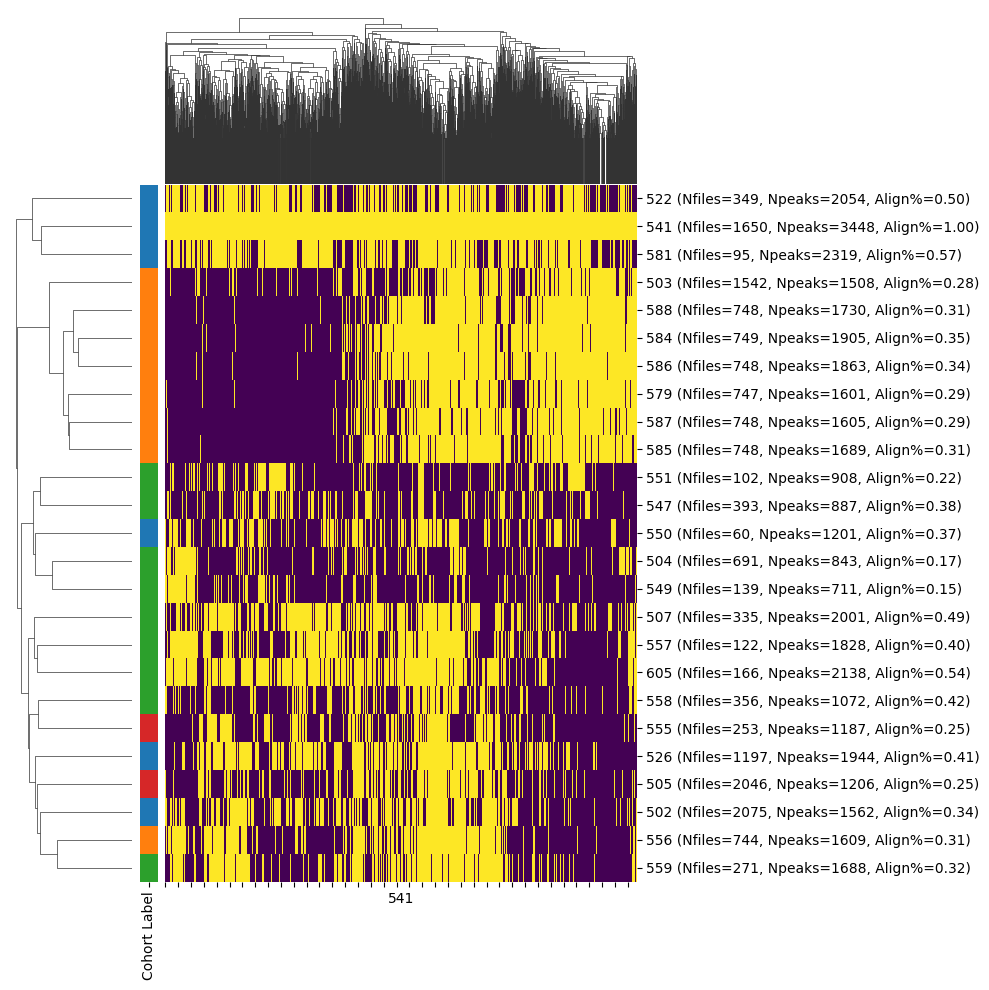

In [199]:

# add extra information to the Align Summary columns (such as the number of samples in each cohort, and peak score)
align_summary_plot = align_summary.copy()
align_summary_bool = align_summary.astype(bool)
align_counts = align_summary_bool.sum(axis=0)
align_summary_plot.columns = [
    f'{c} (Nfiles={cohort_id_to_sample_num.loc[c].values[0]}, Npeaks={align_counts[c]:.0f}, Align%={cohort_id_to_align_score[c]:.2f})' 
    for c in align_summary.columns]



row_colors = pd.Series([cohort_id_to_color[c] for c in align_summary.columns])
row_colors.index = align_summary_plot.columns
row_colors.name = 'Cohort Label'


g = sns.clustermap(align_summary_plot.astype(bool).astype(int).T, cmap='viridis', figsize=(10,10), 
               row_colors=row_colors)

plt.setp(g.ax_heatmap.get_xticklabels(), visible=False)
plt.xlabel('Aligned Features')

# remove the color bar
plt.gcf().axes[-1].remove()



KeyboardInterrupt: 

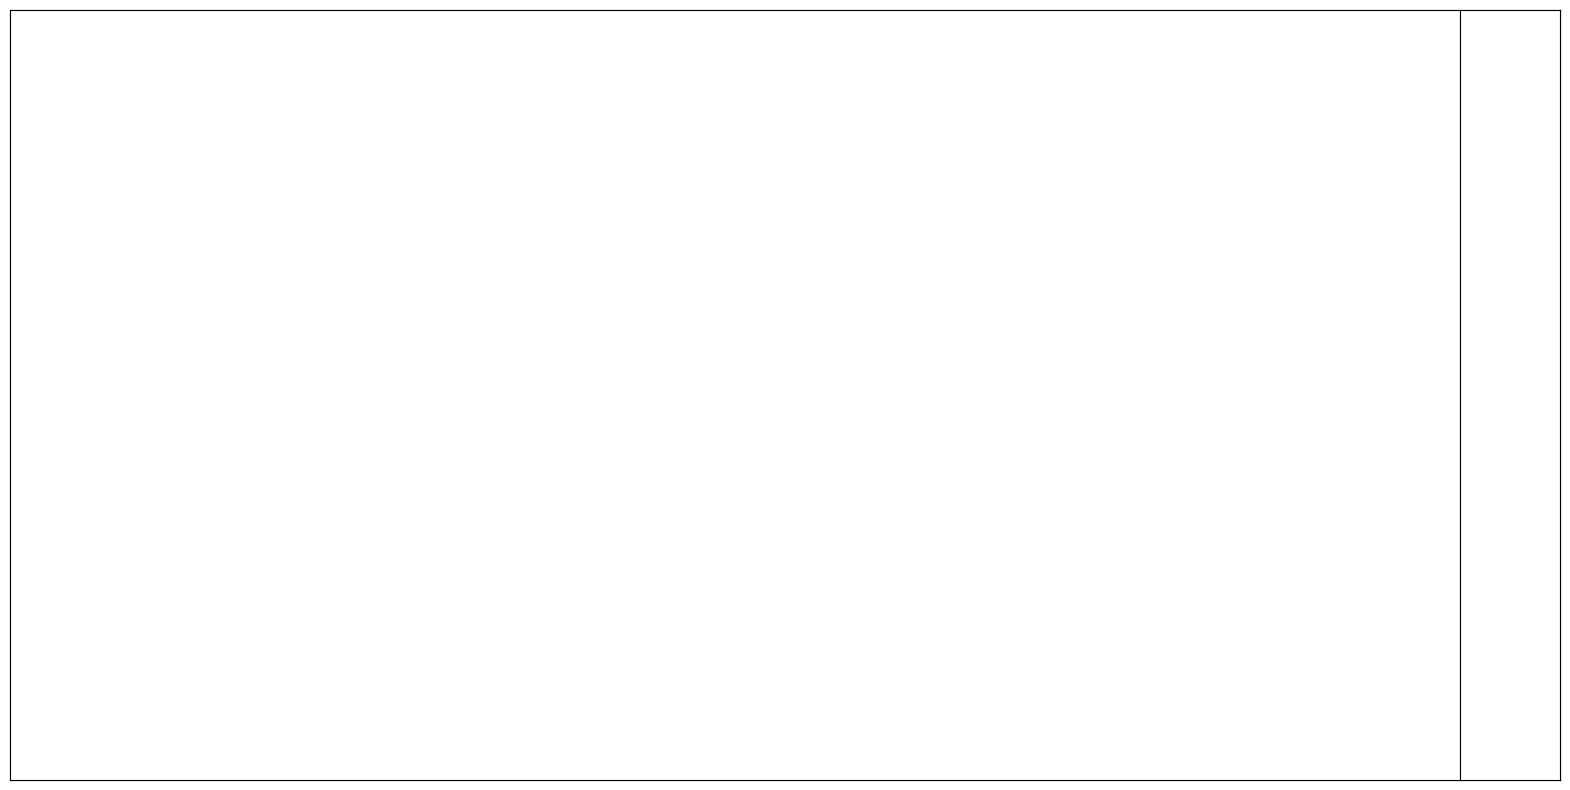

In [170]:
# takes over 7 minutes
plt.figure(figsize=(20, 10))

# supervenn(sets, set_names,min_width_for_annotation=20,side_plots='right') #color_cycle
supervenn(sets, set_names, min_width_for_annotation=20, side_plots='right',color_cycle=[cohort_id_to_color[col] for col in set_names])

## Redo Peak Intensity Analysis

In [ ]:
from sklearn.decomposition import PCA
import umap

In [45]:
combined_study = pd.read_csv(combined_study_file, index_col=0)
combined_study.columns = combined_study.columns.astype(str)

nan_mask = pd.read_csv(nan_mask_file, index_col=0)
nan_mask.columns = nan_mask.columns.astype(str)

In [46]:
print('combined_study shape: ', combined_study.shape)
combined_study = combined_study[metadata_df.index]
nan_mask = nan_mask[metadata_df.index]

# cohort_id_list = metadata_df['Study ID Expanded'].tolist() # is it better to use the study id?

print('combined_study shape after metadata match: ', combined_study.shape)

combined_study shape:  (3293, 16244)
combined_study shape after metadata match:  (3293, 16244)


In [47]:
combined_study_ft_list = combined_study.index.to_list()
if len(combined_study_ft_list) < len(chosen_feats):
    print('There are fewer features in the combined study than in the chosen features')
    print('select the subset of chosen features')
    chosen_feats = [ft for ft in chosen_feats if ft in combined_study_ft_list]
    print('number of chosen features: ', len(chosen_feats))


combined_study = combined_study.loc[chosen_feats,:]
nan_mask = nan_mask.loc[chosen_feats,:]


# combined_study[nan_mask] = np.nan
subset_metadata = metadata_df.copy()
subset_metadata['MV'] = 100*nan_mask.sum(axis=0)/nan_mask.shape[0]



Text(0, 0.5, 'Number of Samples')

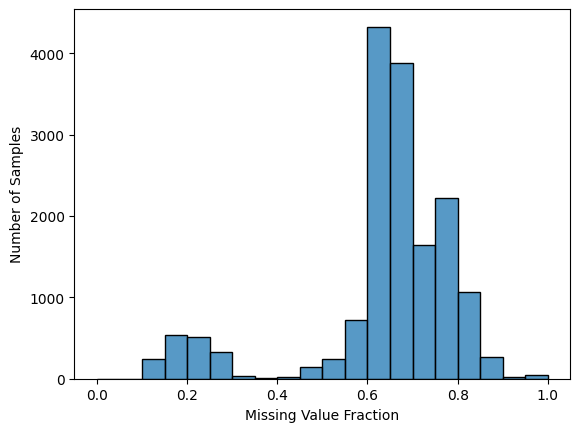

In [48]:
num_missing_vals = nan_mask.sum(axis=0).sort_values(ascending=False)
num_missing_frac = num_missing_vals/combined_study.shape[0]

sns.histplot(num_missing_frac, bins=np.linspace(0,1,21))
plt.xlabel('Missing Value Fraction')
plt.ylabel('Number of Samples')

In [49]:
# Remove samples with more than 95% missing values
mis_val_frac_th = 0.95
print(f'number of samples with more than {100*mis_val_frac_th:.0f}% missing values: ', (num_missing_frac > mis_val_frac_th).sum())
kept_samples = num_missing_frac[num_missing_frac < mis_val_frac_th].index
nan_mask = nan_mask.loc[:,kept_samples]
combined_study = combined_study.loc[:,kept_samples]
subset_metadata = subset_metadata.loc[kept_samples]
cohort_id_list = subset_metadata['Cohort ID Expanded'].tolist()

print('combined_study shape after removing samples with more than 95% missing values: ', combined_study.shape)

number of samples with more than 95% missing values:  46
combined_study shape after removing samples with more than 95% missing values:  (3293, 16198)


In [50]:
# If we want to fill the NA values with something else
combined_study[nan_mask] = np.nan
# we want to split up the RCC cohorts into its subsets
combined_study = fill_na_by_cohort(combined_study, cohort_id_list, method= 'mean_1th')

In [58]:
np.unique(cohort_id_list)

array(['502', '503', '505', '507', '522', '526', '547', '550', '551',
       '555', '556', '557', '558', '559', '579', '581', '584', '585',
       '586', '587', '588', '605', 'RCC1', 'RCC3'], dtype='<U4')

In [51]:
data_corrected = standardize_across_cohorts(combined_study, cohort_id_list, method='zscore')
print('data_corrected shape: ', data_corrected.shape)
# which columns have been removed?
rem_cols = data_corrected.isna().sum() > 0
rem_cols = rem_cols[rem_cols].index
print('Number of columns removed: ', rem_cols.shape[0])
print('Columns removed: ', rem_cols)
data_corrected.dropna(axis=1, inplace=True)
print('data_corrected shape after dropping NA columns: ', data_corrected.shape)
subset_metadata = subset_metadata.loc[data_corrected.columns]

fill missing values with the sample mean
data_corrected shape:  (3293, 16198)
Number of columns removed:  0
Columns removed:  Index([], dtype='object')
data_corrected shape after dropping NA columns:  (3293, 16198)


In [59]:
nan_mask = nan_mask.loc[data_corrected.index, data_corrected.columns]

In [ ]:
nan_mask.to_csv(os.path.join(data_dir, 'subset_nan_mask.csv'))

In [53]:
subset_metadata.to_csv(os.path.join(data_dir, 'subset_metadata.csv'))
data_corrected.to_csv(os.path.join(data_dir, 'subset_data_corrected.csv'))
nan_mask.to_csv(os.path.join(data_dir, 'subset_nan_mask.csv'))

In [54]:
data_dir

'/Users/jonaheaton/ReviveMed Dropbox/Jonah Eaton/development_CohortCombination/alignment_RCC_2024_Feb_27/alignment_id_29/merge_reference_freq_th_0.4_freq_th_0.1'

### PCA Plot

In [ ]:
# Generate the PCA plo

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_corrected.T)
pca_df = pd.DataFrame(pca_result, index=combined_study.columns, columns=['PC1', 'PC2'])
pca_df['MV'] = subset_metadata['MV']
pca_df['Cohort Label'] = subset_metadata['Cohort Label']
pca_df['Study ID'] = subset_metadata['Study ID']
pca_df['Cohort ID'] = subset_metadata['cohort_id']

# save the pca_df
# pca_df.to_csv(pca_file)



In [ ]:
create_plot(pca_df, 'Cohort Label', cohort_label_to_color)

### UMAP Plot

In [ ]:
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(data_corrected.T)
umap_df = pd.DataFrame(umap_result, index=combined_study.columns, columns=['UMAP1', 'UMAP2'])
umap_df['MV'] = subset_metadata['MV']
umap_df['Cohort Label'] = subset_metadata['Cohort Label']
umap_df['Study ID'] = subset_metadata['Study ID']
umap_df['Cohort ID'] = subset_metadata['cohort_id']

# save the umap_df
# umap_df.to_csv(umap_file)



In [ ]:
create_plot(umap_df, 'Cohort Label', cohort_label_to_color)